In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from utils.visual_functions import *
from utils.utils import *
from utils.data_generator import *
import numpy as np
from sklearn.manifold import TSNE
%matplotlib inline
fig_path="../figure/paper/"
seed = 4783957
print("set seed")
np.random.seed(seed)
import torch
from palettable.colorbrewer.qualitative import Pastel1_9
from utils.data_generator import get_data, get_loaders
lilac_names=['1-phase-motor', '3-phase-motor', 'Bulb',
       'Coffee-machine', 'Drilling', 'Dumper',
       'Fluorescent-lamp', 'Freq-conv-squirrel-3-2x', 'Hair-dryer',
       'Kettle', 'Raclette', 'Refrigerator', 'Resistor',
       'Squirrel-3-async', 'Squirrel-3-async-2x', 'Vacuum']
plaid_names = ['CFL','ILB','Waterkettle','Fan','AC','HairIron','LaptopCharger','SolderingIron','Fridge','Vacuum','CoffeeMaker','FridgeDefroster']
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        'axes.labelsize': 12, # fontsize for x and y labels (was 10)
        'axes.titlesize': 12,
        'axes.prop_cycle' : cycler(color=Pastel1_9.hex_colors),
        # Use 10pt font in plots, to match 10pt font in document
        "font.size": 20,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}
matplotlib.rcParams.update(nice_fonts)

set seed


### Functions

In [2]:
def calculatePower(train_current, train_voltage, NN=500):
  

    n = len(current)
    PQ = np.empty([n,2])
    for i in range(n):
        # extract current and voltage in two cycle
        # extract current and voltage in two cycle
        temp_I = current[i]
        temp_V = voltage[i]
        Irms = np.mean(temp_I**2)**0.5
        Vrms = np.mean(temp_V**2)**0.5

        # Instantaneous power: obtained by multiplying the instantaneous voltage and current values
        Pinst = temp_I * temp_V
        Pactive = np.mean(Pinst) 

        # Apparent power: obtained by multiplying the RMS values of voltage and current
        Papparent = Vrms*Irms;

        # Ractive power if power triangle holds:
        Preactive = np.sqrt(Papparent**2 - Pactive**2);




        PQ[i,0]=Pactive
        PQ[i,1]=Preactive
    return PQ



In [27]:
def plot_PQPlane(labels, PQ, legends=None, sample=True):
    
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
        
    clrs = sns.color_palette("Paired", len(Legends))
    markers='1v^<P4ph+DX*8os3<-'
    
    minx,maxx,miny,maxy = (0,0,0,0)
    

    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        if sample:
            ix1 = np.random.randint(PQ.shape[0],size=6)
            tempx = PQ[ix1,0]
            tempy = PQ[ix1,1]
        else:
            tempx = PQ[ix,0]
            tempy = PQ[ix,1]
        plt.scatter(tempx,tempy,marker=markers[i], s=30, label=Legends[i], color=clrs[i])
        minx = min(minx,min(tempx))
        maxx = max(maxx,max(tempx))
        miny = min(miny,min(tempy))
        maxy = max(maxy,max(tempy))    
    plt.axis([minx*0.9,maxx*1.1,miny*0.9,maxy*1.1])
    plt.xlabel('Real Power(W)')
    plt.ylabel('Reactive Power (VAR)')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    
def tsne_visualizer(labels, feature, legends=None):
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
    clrs = sns.color_palette("Paired", len(Legends))
    model  = TSNE(perplexity=20, min_grad_norm=1E-12, n_iter=10000, random_state=42)
    #model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)
    TSNEF  = model.fit_transform(feature.reshape(len(feature), -1))
    
    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=app, color=clrs[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel("tsne-2d-one")
    plt.ylabel("tsne-2d-two")
    
def list_intersection(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    return a_set.intersection(b_set) 



### PLAID

In [28]:
current, voltage, labels, I_max = get_data(data_type="plaid")

Load plaid aggregated data from ../data/plaid/


In [29]:
for x in labels:
    if len(x)==4:
        print(x)

['AC', 'Waterkettle', 'SolderingIron', 'SolderingIron']
['AC', 'CoffeeMaker', 'SolderingIron', 'SolderingIron']
['SolderingIron', 'SolderingIron', 'AC', 'CoffeeMaker']
['SolderingIron', 'SolderingIron', 'CoffeeMaker', 'Vacuum']
['SolderingIron', 'SolderingIron', 'ILB', 'AC']
['CoffeeMaker', 'Vacuum', 'SolderingIron', 'SolderingIron']
['Fridge', 'SolderingIron', 'SolderingIron', 'ILB']
['ILB', 'SolderingIron', 'SolderingIron', 'Fridge']
['Vacuum', 'SolderingIron', 'SolderingIron', 'FridgeDefroster']


In [30]:
active_apps = np.array([len(set(x)) for x in labels])
l, count=np.unique(active_apps, return_counts=True)
volgorde = np.argsort(count)
fig = figure(fig_width=6)
barwidth = 0.4
plt.bar(np.array(l), count, width=barwidth, color="C0", alpha=0.6)
plt.xticks(np.array(l), np.array(["1", '2', '3', '4']));
plt.tight_layout()
ax = plt.gca()  
ax.set_ylabel(f'Counts', fontsize=18)
ax.set_xlabel("",fontsize=20)
        
for p in ax.patches:
        #ax.annotate('{:.0%}'.format(height), (p.get_x()+.15*width, p.get_y() + height + 0.01))
        ax.annotate("${}$".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xlabel(f'Number of active appliances', fontsize=18)     
ax.tick_params(axis='both', which='major', labelsize=18)
format_axes(ax)
ax.autoscale(tight=True)
savefig(fig_path+"active_appliances_distribution_plaid",format=".pdf")

In [31]:
for p in ax.patches:
    print(p)

Rectangle(xy=(0.8, 0), width=0.4, height=674, angle=0)
Rectangle(xy=(1.8, 0), width=0.4, height=413, angle=0)
Rectangle(xy=(2.8, 0), width=0.4, height=67, angle=0)


In [32]:
l, count=np.unique(np.hstack(labels), return_counts=True)
volgorde = np.argsort(count)
height = 0.8
fig = figure(fig_width=6)
plt.barh(np.array(l)[volgorde], count[volgorde], height=height, alpha=0.6)
plt.tight_layout()
plt.tight_layout()
ax = plt.gca()  
ax.set_xlabel(f'Counts', fontsize=20)
#ax.set_ylabel(f'Number of active appliances', fontsize=20)
ax.set_xlabel("",fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.autoscale(tight=True)
savefig(fig_path+"label_distribution_plaid",format=".pdf")

In [33]:
unique_label = []
for l in labels:
    unique_label.append(l)

In [34]:
plaid_labels = []
for x in unique_label: 
    if x not in plaid_labels: 
        plaid_labels.append(x )
len(plaid_labels)

220

In [35]:
plaid_labels_counts = []
for l in plaid_labels:
    plaid_labels_counts.append(unique_label.count(l))

In [36]:
plaid_labels_counts[1]

2

In [37]:
plaid_labels[1]

['Fan', 'AC']

In [38]:
single_app  = ['CFL']
double_app  = ["CFL", "LaptopCharger"]
single_lap  = ["LaptopCharger"]
single_kettle = ['Waterkettle']
cfls = []
cfls_laptop = []
laptops   = []
kettles   = []
for idx in range(len(labels)):
    x=list_intersection(single_app, labels[idx])
    if len(x)==1:
        cfls.append(idx)
        
    x=list_intersection(double_app, labels[idx])
    if len(x)==2:
        cfls_laptop.append(idx)
        
    x=list_intersection(single_lap, labels[idx])
    if len(x)==1:
        laptops.append(idx)   
        
    x=list_intersection(single_kettle, labels[idx])
    if len(x)==1:
        kettles.append(idx)   

In [39]:
ones = []
for i, l in enumerate(labels[cfls]):
    if len(l)==1:
        ones.append(i)
ones

[0,
 2,
 5,
 8,
 9,
 11,
 13,
 15,
 17,
 20,
 21,
 26,
 30,
 33,
 36,
 39,
 47,
 50,
 60,
 63,
 67,
 70,
 71,
 73,
 75,
 77,
 79,
 81,
 83,
 85,
 87,
 89,
 91,
 93,
 94,
 96,
 99,
 101,
 103,
 104,
 107,
 109,
 111,
 112,
 115,
 117,
 119,
 120,
 123,
 125,
 127,
 128]

In [40]:
current_cfl=generate_input_feature(current[cfls], voltage[cfls], "current", width=50,  p=2)

processed: 100 percent: : 130it [00:03, 33.73it/s]


In [41]:
decomposed_current_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_current", width=50,  p=2)

frze processed: 100 percent: : 130it [00:06, 20.61it/s]


In [68]:
x=decomposed_current_cfl[:,0,:]**2 + decomposed_current_cfl[:,1,:]**2
x.shape

torch.Size([130, 50])

In [42]:
distance_cfl=generate_input_feature(current[cfls], voltage[cfls], "distance", width=50,  p=2)
vi_cfl=generate_input_feature(current[cfls], voltage[cfls], "vi", width=50,  p=2)

processed: 100 percent: : 130it [00:04, 31.54it/s]
processed: 130: : 130it [00:00, 149.34it/s]


In [43]:
decomposed_distance_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_distance", width=50,  p=2)
decomposed_vi_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_vi", width=50,  p=2)

frze processed: 100 percent: : 130it [00:06, 20.18it/s]
frze processed: 100 percent: : 130it [00:06, 18.77it/s]
processed: 100 percent: : 130it [00:03, 32.63it/s]
processed: 130: : 130it [00:00, 249.71it/s]
processed: 130: : 130it [00:00, 262.55it/s]


In [49]:
model  = TSNE(perplexity=20, min_grad_norm=1E-12, n_iter=10000, random_state=42)
TSNEF  = model.fit_transform(decomposed_current_cfl.reshape(len(decomposed_distance_cfl), -1))

Text(0, 0.5, 'tsne-2d-two')

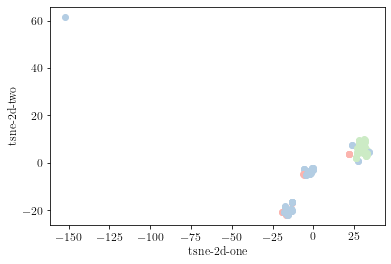

In [50]:
for ix, app in enumerate(labels[cfls]):
    if len(app)==1:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C2')
    if len(app)==2:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C1')
        
    if len(app)==3:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C0')
        
    if len(app)==4:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C4')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")

In [53]:
fig = figure(fig_width=4)
plt.plot(current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
savefig(fig_path+"plaid_event_currents_cfl", format=".pdf")

Text(0.5, 0.6224480268143981, 'sample $w$')

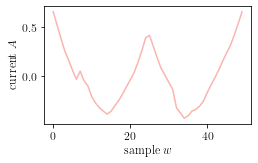

In [56]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
#savefig(fig_path+"plaid_decomposed_currents_active", format=".pdf")

Text(0.5, 0.6224480268143981, 'sample $w$')

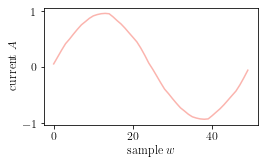

In [57]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][1])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
#savefig(fig_path+"plaid_decomposed_currents_non_active", format=".pdf")

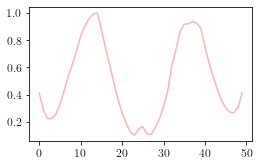

In [76]:
fig = figure(fig_width=4)
x=decomposed_current_cfl[1][1]**2 +decomposed_current_cfl[1][0]**2
x=x/x.max()

plt.plot(x)

In [ ]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][1]+decomposed_current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
savefig(fig_path+"plaid_decomposed_currents_non_active_plus_active", format=".pdf")

In [46]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(vi_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_vi_cfl", format=".pdf")

In [48]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(distance_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_distance_cfl", format=".pdf")

In [49]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_distance_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_distance_cfl_active", format=".pdf")


In [50]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_distance_cfl[1][1], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_distance_cfl_non_active", format=".pdf")

In [51]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_vi_cfl[1][1], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_vi_cfl_non_active", format=".pdf")

In [52]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_vi_cfl[1][0],cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_vi_cfl_active", format=".pdf")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
mlb = MultiLabelBinarizer()
mlb.fit(labels)
y = mlb.transform(labels)

In [ ]:
PQ=calculatePower(current, voltage, NN=500)

In [ ]:
fig=figure(fig_width=7, fig_height=5)
plot_PQPlane(y, PQ, None, sample=False)
#savefig(fig_path+"plaid_PQ_plane",format=".pdf")

### Feature embending 

In [ ]:
dist = cfl_dist
v_dist = generate_input_feature(voltage, voltage, "rp", width=50, multi_dimension=False, p=2)
WRG  = get_weighted_reccurrence_graph(dist, delta=10, eps=20)
RP   = get_binary_reccurrence_graph(dist, eps=0.05)

WRGV  = get_weighted_reccurrence_graph(v_dist, delta=10, eps=20)
RPV   = get_binary_reccurrence_graph(v_dist, eps=0.05)

In [ ]:
#WRG = torch.cat([WRG, WRGV], 1)
BRP = torch.cat([RP, RPV], 1)

In [ ]:
#RP = generate_input_feature(current, voltage, "adaptive", width=50, multi_dimension=True).numpy()
VI = generate_input_feature(current, voltage, "vi", width=50, multi_dimension=False).numpy()

In [ ]:
fig=figure(fig_width=5, fig_height=5)
tsne_visualizer(plaid_label,current, legends=None)
#savefig(fig_path+"tsne_feature_VI",format=".pdf")

In [ ]:
savefig(fig_path+"tsne_feature_current",format=".pdf")

In [ ]:
fig=figure(fig_width=5, fig_height=5)
tsne_visualizer(plaid_label, VI, legends=None)

In [ ]:
savefig(fig_path+"tsne_feature_vi",format=".pdf")

In [ ]:
fig=figure(fig_width=5, fig_height=5)
tsne_visualizer(plaid_label, BRP, legends=None)


In [ ]:
savefig(fig_path+"tsne_feature_brp",format=".pdf")

In [ ]:
fig=figure(fig_width=5, fig_height=5)
tsne_visualizer(plaid_label, WRG, legends=None)


In [ ]:
savefig(fig_path+"tsne_feature_wrg",format=".pdf")

In [ ]:
1/1e3

## Visualize learned representation

In [ ]:
class Conv2DVI(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.2):
        super(Conv2DVI, self).__init__()
        self.in_size=in_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_size, 16, 5, 2),
            nn.ReLU()
            #nn.MaxPool2d(3, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 2),
            nn.ReLU()
            #nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.fc_out=nn.Sequential(
            nn.Linear(64, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, out_size)
            )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x= self.fc_out(x)
        return x

In [ ]:
from data_generator import *
from model import *
from utils import *
from fit_functions import *
dataset="plaid"
image_type="vi"
width=50
model_name="CNN"
run_id=1
file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}__exp_two"
saved_model_path   = '../checkpoint/plaid_vi_50_CNN_1__exp_two_checkpoint.pt'
checkpoint = Checkpoint(saved_model_path, patience=100, checkpoint=True, score_mode="max",min_delta=1e-4)
model_vi = Conv2DVI(1, out_size=12, dropout=0.2)
model_vi=checkpoint.load_saved_model(model_vi)
model_vi = model_vi.eval()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels)
vi_data = Dataset(torch.tensor(VI), y)
loader=torch.utils.data.DataLoader(vi_data, 32, shuffle=False, num_workers=4, drop_last=False)
target = []
latent_feature = []
with torch.no_grad():
    for i, data in enumerate(loader):
        inp, targ=data
        out = model_vi(inp)
        latent_feature.append(out.data.numpy())
        target.append(targ.numpy())

In [ ]:
target = np.hstack(target)
latent_feature=np.concatenate(latent_feature, 0)
model = TSNE(perplexity=40, min_grad_norm=1E-12, n_iter=3000)
TSNEF  = model.fit_transform(latent_feature)

In [ ]:
fig=figure(fig_width=4, fig_height=2.25)
clrs =sns.color_palette("Paired", 12)
for i in np.unique(target):
    ix=np.where(target==i)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=plaid_names[i], color=clrs[i])
leg=plt.legend(bbox_to_anchor=(1.01, 1), loc=2, fontsize=8, frameon=False)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.tight_layout()
savefig(fig_path+"tsne_latent_feature_VI_plaid",format=".pdf")

### RP

In [ ]:
image_type="adaptive"
width=50
model_name="CNN"
run_id=1
saved_model_path   = '../checkpoint/plaid_adaptive_50_CNN_1_parameters_emb_size_10_10_checkpoint.pt'
checkpoint = Checkpoint(saved_model_path, patience=100, checkpoint=True, score_mode="max",min_delta=1e-4)
model_rp = Conv2DAdaptiveRecurrence(in_size=1, out_size=12,
                                            dropout=0.2)
model_rp=checkpoint.load_saved_model(model_rp)
model_rp=model_rp
rp_data = Dataset(torch.tensor(RP), y)
loader=torch.utils.data.DataLoader(rp_data, 32, shuffle=False, num_workers=4, drop_last=False)
target = []
latent_feature = []
with torch.no_grad():
    for i, data in enumerate(loader):
        inp, targ=data
        out = model_rp(inp)
        latent_feature.append(out.data.numpy())
        target.append(targ.numpy())

In [ ]:
target = np.hstack(target)
latent_feature=np.concatenate(latent_feature, 0)
model = TSNE(perplexity=40, min_grad_norm=1E-12, n_iter=3000)
TSNEFP  = model.fit_transform(latent_feature)

In [ ]:
fig=figure(fig_width=4, fig_height=2.25)
clrs =sns.color_palette("Paired", 12)
for i in np.unique(target):
    ix=np.where(target==i)[0]
    plt.scatter(TSNEFP[ix,0], TSNEFP [ix,1],label=plaid_names[i], color=clrs[i])
leg=plt.legend(bbox_to_anchor=(1.01, 1), loc=2, fontsize=8, frameon=False)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.tight_layout()
savefig(fig_path+"tsne_latent_feature_RP_plaid",format=".pdf")

### Industrial

In [ ]:
current, voltage, labels = load_data("lilac", submetered=False)
c, l=np.unique(labels, return_counts=True)
volgorde = np.argsort(l)
fig = figure(fig_width=5, fig_height=3.75)
plt.barh(np.array(lilac_names)[volgorde], l[volgorde], alpha=0.5)
plt.xlabel("Number of examples")
plt.tight_layout()
savefig(fig_path+"label_distribution_lilac",format=".pdf")

In [ ]:
np.unique(labels)
res_app=['Coffee-machine', 'Drilling-machine', 'Kettle', 'Raclette', 'Refrigerator', 'Vacuum-cleaner', 'Hair-dryer', 'Bulb']
indust_app = []
for l in np.unique(labels):
    if l not in res_app:
        indust_app.append(l)

In [ ]:
## three phase
motor = np.where(labels=='Squirrel-3-async-2x')[0]
x = current[motor[20]]

In [ ]:
fig =figure(fig_width=3.5, fig_height=2.5)
plt.plot(x[0], label="phase-1")
#plt.plot(x[1], label="phase-2")
#plt.plot(x[2], label="phase-3")
plt.xlabel("sample $N$")
plt.ylabel("current $(A)$")
ax = plt.gca()
ax.minorticks_on()
ax.grid(which='both', linestyle='--', alpha=0.1)
ax.grid(which='minor', alpha=0.2)
plt.xlim(0, 1000)
plt.tight_layout()
#plt.legend()
savefig(fig_path+"input_signal_industrial_three_phase_1",format=".pdf")

In [ ]:
fig =figure(fig_width=3.5, fig_height=2.5)
plt.plot(x[1], label="phase-2")
plt.xlabel("sample $N$")
plt.ylabel("current $(A)$")
ax = plt.gca()
ax.minorticks_on()
ax.grid(which='both', linestyle='--', alpha=0.1)
ax.grid(which='minor', alpha=0.2)
plt.xlim(0, 1000)
plt.tight_layout()
savefig(fig_path+"input_signal_industrial_three_phase_2",format=".pdf")

In [ ]:
fig =figure(fig_width=3.5, fig_height=2.5)
plt.plot(x[2], label="phase-3")
plt.xlabel("sample $N$")
plt.ylabel("current $(A)$")
ax = plt.gca()
ax.minorticks_on()
ax.grid(which='both', linestyle='--', alpha=0.1)
ax.grid(which='minor', alpha=0.2)
plt.xlim(0, 1000)
plt.tight_layout()
savefig(fig_path+"input_signal_industrial_three_phase_3",format=".pdf")

In [ ]:
fig =figure(fig_width=4, fig_height=3)
dril = np.where(labels=='Drilling-machine')[0]
y = current[dril[10]]
v = voltage[dril[10]]
plt.plot(y[0], label="phase-1")
plt.plot(y[1], label="phase-2")
plt.plot(y[2], label="phase-3")
plt.legend()
plt.xlabel("sample $N$")
plt.ylabel("current $A$")
#plt.ylim(-1,1)
plt.tight_layout()
savefig(fig_path+"input_signal_industrial_single_phase_DL",format=".pdf")

In [ ]:
## PQ plane

In [ ]:
PQ = []
for k in range(3):
    PQ+=[calculatePower(current[:,k,:], voltage[:,k,:], NN=500)]
PQ = np.array(PQ)

In [ ]:
PQT=PQ.sum(0)
fig=figure(fig_width=8)
plot_PQPlane(labels, PQT, None, sample=False)
savefig(fig_path+"lilac_PQ_plane",format=".pdf")

In [ ]:
dist = create_N_distance_similarity_matrix(x, 50, 1)
model = ReccurrentBlock()
out = model(dist)
img = out.detach()[0]
fig = figure(fig_width=2, fig_height=2)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_one_sq_1",format=".pdf")

In [ ]:

out = model(dist)
img = out.detach()[1]
fig = figure(fig_width=2, fig_height=2)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_one_sq_2",format=".pdf")

In [ ]:

img = out.detach()[2]
fig = figure(fig_width=2, fig_height=2)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_one_sq_3",format=".pdf")

In [ ]:
dist = create_N_distance_similarity_matrix(y, 50, 1)
model = ReccurrentBlock()
out = model(dist)
img = out.detach()[0]
fig = figure(fig_width=3, fig_height=3)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_phase_drill_1",format=".pdf")

In [ ]:
img = out.detach()[1]
fig = figure(fig_width=3, fig_height=3)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_phase_2_drill",format=".pdf")

In [ ]:
img = out.detach()[2]
fig = figure(fig_width=3, fig_height=3)
plt.imshow(img, cmap='YlGnBu', origin='lower')
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"rcp_lilac_phase_3_drill",format=".pdf")

In [ ]:
RP = generate_input_feature(current, voltage, "adaptive", width=50, multi_dimension=True).numpy()
#

In [ ]:
len(RP)

In [ ]:
VI = generate_input_feature(current, voltage, "vi", width=50, multi_dimension=True).numpy()

In [ ]:
fig=figure(fig_width=6, fig_height=6)
tsne_visualizer(labels, VI, legends=None)
savefig(fig_path+"tsne_feature_VI_lilac",format=".pdf")

In [ ]:
fig=figure(fig_width=6, fig_height=6)
tsne_visualizer(labels, RP, legends=None)
savefig(fig_path+"tsne_feature_RP_lilac",format=".pdf")

## Visualize learned representation VI

In [ ]:
dataset="lilac"
image_type="vi"
width=50
model_name="CNN"
run_id=1
saved_model_path   = '../checkpoint/lilac_vi_50_CNN_1__exp_two_checkpoint.pt'
checkpoint = Checkpoint(saved_model_path, patience=100, checkpoint=True, score_mode="max",min_delta=1e-4)
model = Conv2DVI(3, out_size=16, dropout=0.2)
model_vi=checkpoint.load_saved_model(model)
model_vi = model_vi.eval()


In [ ]:
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels)
vi_data = Dataset(torch.tensor(VI), y)
loader=torch.utils.data.DataLoader(vi_data, 32, shuffle=False, num_workers=4, drop_last=False)
target = []
latent_feature = []
with torch.no_grad():
    for i, data in enumerate(loader):
        inp, targ=data
        out = model_vi(inp)
        latent_feature.append(out.data.numpy())
        target.append(targ.numpy())

In [ ]:
target = np.hstack(target)
latent_feature=np.concatenate(latent_feature, 0)
model = TSNE(perplexity=40, min_grad_norm=1E-12, n_iter=3000)
TSNEF  = model.fit_transform(latent_feature)

In [ ]:
fig=figure(fig_width=4, fig_height=3.5)
clrs =sns.color_palette("Paired", 16)
for i in np.unique(target):
    ix=np.where(target==i)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=lilac_names[i], color=clrs[i])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
savefig(fig_path+"tsne_latent_feature_VI_lilac",format=".pdf")

In [ ]:
### RP

In [ ]:
image_type="adaptive"
width=50
model_name="CNN"
run_id=1
file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}__exp_two"
saved_model_path   = '../checkpoint/lilac_adaptive_50_CNN_1_parameters_emb_size_10_10_checkpoint.pt'
checkpoint = Checkpoint(saved_model_path, patience=100, checkpoint=True, score_mode="max",min_delta=1e-4)
model_rp = Conv2DAdaptiveRecurrence(in_size=3, out_size=16,
                                            dropout=0.2)
model_rp=checkpoint.load_saved_model(model_rp)
model_rp=model_rp
rp_data = Dataset(torch.tensor(RP), y)
loader=torch.utils.data.DataLoader(rp_data, 32, shuffle=False, num_workers=4, drop_last=False)
target = []
latent_feature = []
with torch.no_grad():
    for i, data in enumerate(loader):
        inp, targ=data
        out = model_rp(inp)
        latent_feature.append(out.data.numpy())
        target.append(targ.numpy())

In [ ]:
target = np.hstack(target)
latent_feature=np.concatenate(latent_feature, 0)
model = TSNE(perplexity=40, min_grad_norm=1E-12, n_iter=3000)
TSNEF  = model.fit_transform(latent_feature)

In [ ]:
fig=figure(fig_width=4, fig_height=3.5)
clrs =sns.color_palette("Paired", 16)
for i in np.unique(target):
    ix=np.where(target==i)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=lilac_names[i], color=clrs[i])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
savefig(fig_path+"tsne_latent_feature_RP_lilac",format=".pdf")

### PLAID